In [4]:
import sys
import os
import codecs
import pickle
import re
import string
import unicodedata as ud
from pyvi import ViTokenizer, ViPosTagger

def sylabelize(text):
    text = ud.normalize('NFC', text)

    specials = ["==>", "->", "\.\.\.", ">>"]
    digit = "\d+([\.,_]\d+)+"
    email = "([a-zA-Z0-9_.+-]+@([a-zA-Z0-9-]+\.)+[a-zA-Z0-9-]+)"
    #web = "^(http[s]?://)?(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+$"
    web = "\w+://[^\s]+"
    #datetime = [
    #    "\d{1,2}\/\d{1,2}(\/\d{1,4})(^\dw. )+",
    #    "\d{1,2}-\d{1,2}(-\d+)?",
    #]
    word = "\w+"
    non_word = "[^\w\s]"
    abbreviations = [
        "[A-ZĐ]+\.",
        "Tp\.",
        "Mr\.", "Mrs\.", "Ms\.",
        "Dr\.", "ThS\."
    ]

    patterns = []
    patterns.extend(abbreviations)
    patterns.extend(specials)
    patterns.extend([web, email])
    #patterns.extend(datetime)
    patterns.extend([digit, non_word, word])

    patterns = "(" + "|".join(patterns) + ")"
    if sys.version_info < (3, 0):
        patterns = patterns.decode('utf-8')
    tokens = re.findall(patterns, text, re.UNICODE)

    return text, [token[0] for token in tokens]

text, tmp = sylabelize(txt) 

NameError: name 'txt' is not defined

In [8]:

ViPosTagger.postagging(ViTokenizer.tokenize(u"Trường đại học Bách Khoa Hà Nội"))


(['Trường', 'đại_học', 'Bách_Khoa', 'Hà_Nội'], ['N', 'N', 'Np', 'Np'])

In [1]:

from pyvi import ViUtils
ViUtils.remove_accents(u"Trường đại học bách khoa hà nội")


b'Truong dai hoc bach khoa ha noi'

In [2]:

from pyvi import ViUtils
ViUtils.add_accents(u'truong dai hoc bach khoa ha noi')

'Trường Đại học Bách Khoa hà nội'

# Tách câu tiếng việt

In [1]:
def concat_sents(orin, sent):
    return orin.append(sent)

def print_tokens(tokens, postag):
    for i in range(len(tokens)):
        print(tokens[i],' -> ', postag[i])

def get_sents(tokens, postag):
    snts = []
    txt = ""
    for i in range(len(tokens)):
        txt += " "+tokens[i]
        if str(postag[i]) == 'F' and tokens[i] == '.':
            snts.append(txt)
            txt = ""
    return [ item.strip() for item in snts ]

In [2]:

def is_relation_candidate(postag):
    deps = ["V", "A"] 
    return any(subs in postag for subs in deps)

def is_construction_candidate(postag):
    deps = ["C", "E"]
    return any(subs in postag for subs in deps)


In [103]:
def list2str(arr):
    return " ".join(arr)

def get_object_relation_candidate(snt):
    subject = []
    obj = []
    relation = []
    subjectConstruction = ""
    objectConstruction = "" 
    extraction_info = []
    tkns, pos_tag = ViPosTagger.postagging(ViTokenizer.tokenize(snt)) 
    for i in range(len(pos_tag)):
        if 'F' in pos_tag[i]:
            continue
        if is_relation_candidate(pos_tag[i]): 
            relation.append(tkns[i].lower()) 
            extraction_info.append((tkns[i].lower(),pos_tag[i]))
        if is_construction_candidate(pos_tag[i]): 
            if subjectConstruction:
                subjectConstruction.append(tkns[i])
            if objectConstruction:
                objectConstruction.append(tkns[i]) 
        if 'N' == pos_tag[i]:
            subject.append(tkns[i]) 
            extraction_info.append((list2str(subjectConstruction) + tkns[i].lower(),pos_tag[i]))
            subjectConstruction = []
        if 'Np' in pos_tag[i]:
            if pos_tag[i-1] is not None and 'Nc' in pos_tag[i-1]: 
                obj.append(tkns[i-1])
#                 extraction_info.append((tkns[i-1], pos_tag[i-1]))
            obj.append(tkns[i])
            extraction_info.append((list2str(objectConstruction) + tkns[i], pos_tag[i]))
            objectConstruction = []
        if 'M' in pos_tag[i]:
            extraction_info.append((tkns[i].lower(), pos_tag[i]))
    return extraction_info 

def get_noun_phrases(extract_info):
    final_extract = []
    noun_phrases = []
    verb_phrases = []
    index = 0
    for item in extract_info:
        word, tag = item
        if 'N' in tag or 'M' in tag: 
            noun_phrases.append(word)
            if extract_info.index(item) == len(extract_info) -1:
                if len(noun_phrases) != 0 and list2str(noun_phrases) not in final_extract:
                    final_extract.append((list2str(noun_phrases),'N_Phrases',index+1))  
        else:
            if len(noun_phrases) != 0 and list2str(noun_phrases) not in final_extract:
                final_extract.append((list2str(noun_phrases),'N_Phrases',index))
            noun_phrases = []  
            
        if 'V' in tag or 'A' in tag:
            verb_phrases.append(word)
            if extract_info.index(item) == len(extract_info) -1:
                if len(verb_phrases) != 0 and list2str(verb_phrases) not in final_extract:
                    final_extract.append((list2str(verb_phrases),'V_Phrases',index))  
        else:
            if len(verb_phrases) != 0 and list2str(verb_phrases) not in final_extract:
                final_extract.append((list2str(verb_phrases),'V_Phrases',index))
                index+=1
            verb_phrases = []      
    return final_extract


In [104]:

import networkx as nx
import matplotlib.pyplot as plt 


def make_color_edge(G):
    color_edges = ['black'] * len(G.edges) 
    return color_edges

def printGraph(graph_info):
    G = nx.Graph()
    list_N = ['N', 'N_Phrases', 'M']
    edge_values = {}
    for snt in snt_graph_info:
        for info in snt: 
            word, tag, index = info 
            if 'V_Phrases' in tag:
                for s in snt:
                    if s[2] == index and s[1] in list_N:
                        v1 = s
                    if s[2] == index +1 and s[1] in list_N:
                        v2 = s
                if v1 and v2 and v1[0].lower() != v2[0].lower() :
                    G.add_edge(v1[0], v2[0],length=len(word)*10) 
                    edge_values[(v1[0],v2[0])] = word 
    for key, value in edge_values.items():
        print(key, ': ', value)
    pos = nx.spring_layout(G) 
    fig, ax = plt.subplots(figsize=(20,20),dpi=100)
    ax.set_facecolor('xkcd:salmon')
    ax.set_facecolor((0.9, 0.9, 0.9))
    nx.draw(G, pos, edge_color='black', width=0.9, linewidths=0.8,
            node_size=[len(v) *40 for v in G.nodes()], node_color='seagreen', alpha=0.8,
            labels={node: node for node in G.nodes()}, with_labels=True) 
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_values)
    plt.axis('off')
    plt.show() 

In [105]:

SPECIAL_CHARACTER = '%@$=+-!;()*"&^:#|\n\t\''
def arrange_punct(text):
    text = text.replace(' ,',',')
    text = text.replace(' .','.') 
    text = text.replace(' / ','/')
    return text.strip()

def remove_stopword(text):
    with open('stopwords-nlp-vi.txt', 'r') as f:
        stopwords = set([w.strip().replace(' ', '_') for w in f.readlines()])
    split_words = [x.strip(SPECIAL_CHARACTER) for x in text.split()]
    return [word for word in split_words if word.encode('utf-8') not in stopwords]



print(list2str(remove_stopword(arrange_punct(sentences[0]))))
print(sentences[0])

Trong các cơ_chế đặc_thù được đề_xuất dành cho Hà_Nội, có việc cho phép thành_phố được sử_dụng nguồn cải_cách tiền_lương còn dư để chi các dự_án đầu_tư phát_triển và chi thực_hiện các chế_độ, chính_sách an_sinh xã_hội  được hưởng toàn_bộ số thu từ sắp_xếp, cổ_phần_hóa doanh_nghiệp Nhà_nước, thoái vốn Nhà_nước đầu_tư tại các doanh_nghiệp do UBND Thành_phố làm đại_diện chủ sở_hữu vốn Nhà_nước.
Trong các cơ_chế đặc_thù được đề_xuất dành cho Hà_Nội , có việc cho phép thành_phố được sử_dụng nguồn cải_cách tiền_lương còn dư để chi các dự_án đầu_tư phát_triển và chi thực_hiện các chế_độ , chính_sách an_sinh xã_hội ; được hưởng toàn_bộ số thu từ sắp_xếp , cổ_phần_hóa doanh_nghiệp Nhà_nước , thoái vốn Nhà_nước đầu_tư tại các doanh_nghiệp do UBND Thành_phố làm đại_diện chủ sở_hữu vốn Nhà_nước .


In [109]:
text = "Tỉnh Quảng Ninh khẳng định việc ông Nguyễn Văn Thắng, Chủ tịch UBND tỉnh này, kiêm nhiệm chức Hiệu trưởng Trường đại học Hạ Long, là đúng quy định pháp luật. Ngày 21/5, UBND tỉnh Quảng Ninh đã chính thức lên tiếng về việc Chủ tịch tỉnh này kiêm nhiệm chức Hiệu trưởng Trường đại học Hạ Long, đang gây xôn xao dư luận. Theo đó, UBND tỉnh Quảng Ninh khẳng định, việc ông Nguyễn Văn Thắng kiêm nhiệm chức Hiệu trưởng Trường đại học Hạ Long là đúng quy định pháp luật; đồng thời đáp ứng yêu cầu phát triển của địa phương, cũng như của Trường đại học Hạ Long trong thời gian tới. Cũng theo UBND tỉnh Quảng Ninh, từ tháng 1.2020, khi bà Vũ Thị Thu Thủy, nguyên Phó chủ tịch UBND tỉnh, Hiệu trưởng Trường đại học Hạ Long, nhận quyết định nghỉ hưu, thì đến đầu tháng 5, nhà trường chưa kiện toàn được chức danh hiệu trưởng. Điều này phần nào đã ảnh hưởng đến công tác lãnh đạo, điều hành của đơn vị."
text = "Trong các cơ chế đặc thù được đề xuất dành cho Hà Nội, có việc cho phép thành phố được sử dụng nguồn cải cách tiền lương còn dư để chi các dự án đầu tư phát triển và chi thực hiện các chế độ, chính sách an sinh xã hội; được hưởng toàn bộ số thu từ sắp xếp, cổ phần hóa doanh nghiệp Nhà nước, thoái vốn Nhà nước đầu tư tại các doanh nghiệp do UBND Thành phố làm đại diện chủ sở hữu vốn Nhà nước."
# text = "Đoạn tuyến này sẽ nối dài tuyến đường sắt đô thị số 3, đoạn Nhổn - ga Hà Nội ở ga Trung tâm; kết nối với tuyến đường sắt đô thị số 2 tại ga Hàng Bài; tuyến đường sắt đô thị số 4 tại đường Vành đai 2,5; tuyến đường sắt đô thị số 8 tại đường Vành đai 3, tạo nên sự gắn kết của mạng lưới đường sắt đô thị."
# text = "Theo kế hoạch, dự án này sẽ hoàn thành vào năm 2015. Tổng mức đầu tư được UBND TP Hà Nội phê duyệt lần đầu 19.555 tỷ đồng. Tuy nhiên, mới đây, chính quyền thành phố báo cáo Thủ tướng xin phê duyệt điều chỉnh tổng mức đầu tư dự án lên 35.678 tỷ đồng (tăng 16.123 tỷ đồng) so với ban đầu."
# text = "Chủ tịch UBND Hà Nội Nguyễn Đức Chung vừa trình Thủ tướng nghiên cứu, thiết kế quy hoạch tổng mặt bằng và phương án thi công ga ngầm C9 (ga hồ Hoàn Kiếm) thuộc dự án đầu tư xây dựng tuyến đường sắt đô thị số 2, đoạn Nam Thăng Long - Trần Hưng Đạo."
# text = "Chiều 1/6, MC Trấn Thành đã có buổi làm việc trực tiếp với 2 chủ tài khoản tung tin đồn về anh trước đó. \
#         Theo phía nam MC, vụ việc đã được giải quyết.\
#         Tối 29/5, khán giả xôn xao trước hình ảnh chụp tin nhắn có nội dung Trấn Thành ăn chơi, 'bay lắc' cùng nhóm bạn được chia sẻ rộng rãi trên mạng xã hội. \
#         Ngay lập tức, MC bày tỏ sự bức xúc qua trang cá nhân.\
#         Anh khẳng định đó là tin nhắn giả mạo nhằm bôi nhọ danh dự.\
#         MC Trấn Thành cũng cho biết sẽ giải quyết vụ việc theo pháp luật. Anh kêu gọi cộng đồng mạng tìm ra chủ tài khoản tung tin đồn, thậm chí treo thưởng 5 triệu đồng cho ai làm được việc này."
tokens, postag = ViPosTagger.postagging(ViTokenizer.tokenize(text))    
sentences = get_sents(tokens, postag)  
snt_graph_info = []

print("Before:","\n\t",text,len(sentences))
for snt in sentences:
    print(snt)
    extract_info = get_object_relation_candidate(snt) 
    extract_info = get_noun_phrases(extract_info)
    snt_graph_info.append(extract_info.copy())
    
    print("\t\t\t\t==================================\n")
    ex = list2str([ word for word, tag, index in extract_info])
    print("After:","\n\t",ex)
    print("==================================================\n")
    
    print("Extract about: ",len(ex)/len(snt) *100, " %\n")
    print("\t\t\t\tGRAPH INFO")
    
# print(snt_graph_info)

Before: 
	 Trong các cơ chế đặc thù được đề xuất dành cho Hà Nội, có việc cho phép thành phố được sử dụng nguồn cải cách tiền lương còn dư để chi các dự án đầu tư phát triển và chi thực hiện các chế độ, chính sách an sinh xã hội; được hưởng toàn bộ số thu từ sắp xếp, cổ phần hóa doanh nghiệp Nhà nước, thoái vốn Nhà nước đầu tư tại các doanh nghiệp do UBND Thành phố làm đại diện chủ sở hữu vốn Nhà nước. 1
Trong các cơ_chế đặc_thù được đề_xuất dành cho Hà_Nội , có việc cho phép thành_phố được sử_dụng nguồn cải_cách tiền_lương còn dư để chi các dự_án đầu_tư phát_triển và chi thực_hiện các chế_độ , chính_sách an_sinh xã_hội ; được hưởng toàn_bộ số thu từ sắp_xếp , cổ_phần_hóa doanh_nghiệp Nhà_nước , thoái vốn Nhà_nước đầu_tư tại các doanh_nghiệp do UBND Thành_phố làm đại_diện chủ sở_hữu vốn Nhà_nước .

After: 
	 cơ_chế đặc_thù đề_xuất dành Hà_Nội có việc cho phép thành_phố được sử_dụng nguồn cải_cách tiền_lương dư chi dự_án đầu_tư phát_triển thực_hiện chế_độ chính_sách an_sinh xã_hội được 

('cơ_chế', 'Hà_Nội') :  đặc_thù đề_xuất dành
('Hà_Nội', 'việc') :  có
('việc', 'phép thành_phố') :  cho
('phép thành_phố', 'nguồn') :  được sử_dụng
('nguồn', 'tiền_lương') :  cải_cách
('tiền_lương', 'dự_án') :  dư chi
('dự_án', 'chế_độ chính_sách') :  đầu_tư phát_triển thực_hiện
('chế_độ chính_sách', 'xã_hội') :  an_sinh
('xã_hội', 'toàn_bộ số') :  được hưởng
('toàn_bộ số', 'sắp_xếp') :  thu
('sắp_xếp', 'doanh_nghiệp nhà_nước') :  cổ_phần_hóa
('doanh_nghiệp nhà_nước', 'vốn nhà_nước') :  thoái
('vốn nhà_nước', 'doanh_nghiệp thành_phố') :  đầu_tư
('doanh_nghiệp thành_phố', 'đại_diện chủ') :  làm


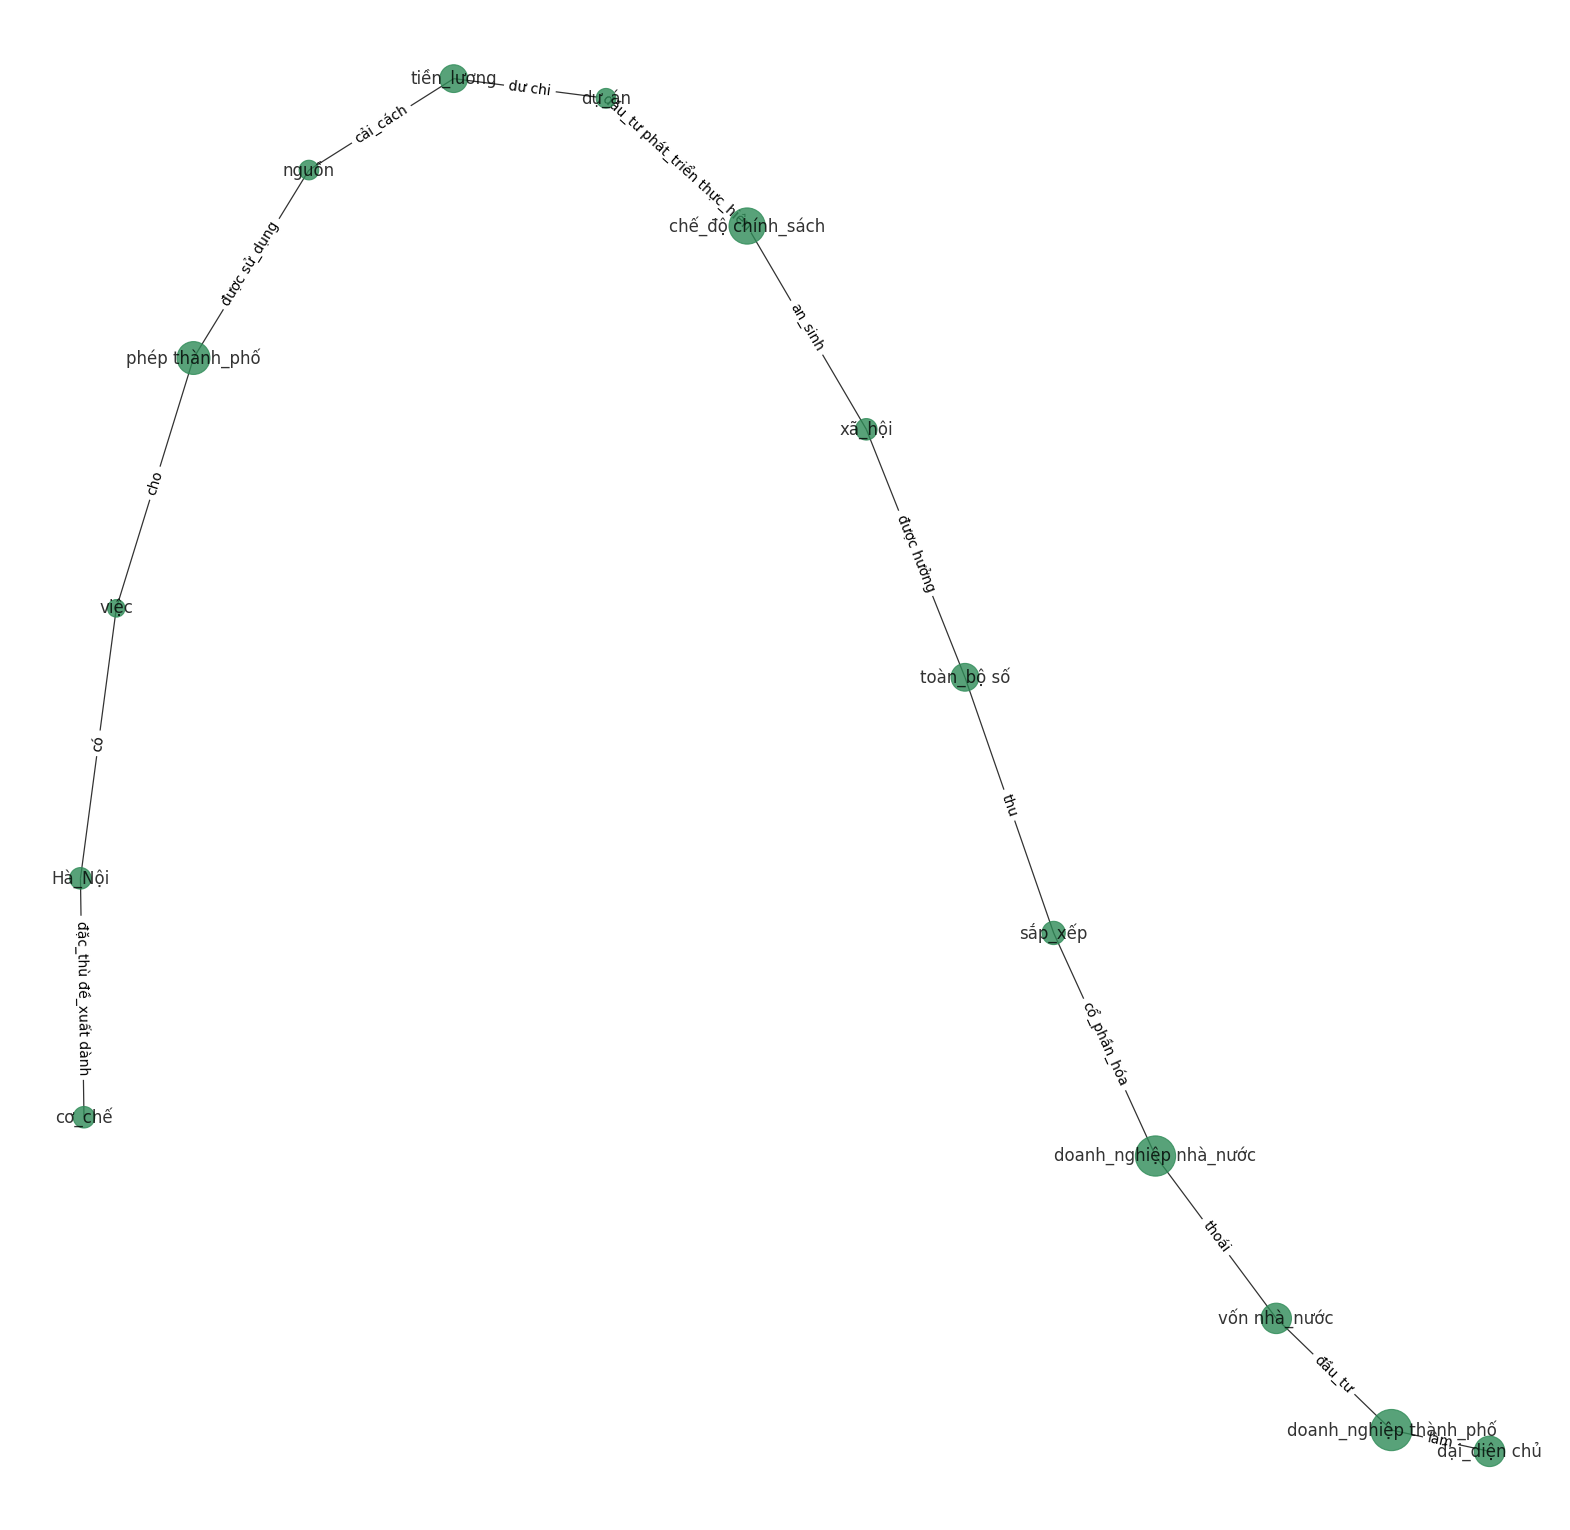

In [107]:
printGraph(snt_graph_info)

In [118]:
 
from underthesea import chunk
import sklearn_crfsuite 
ESTIMATE_PROBLEM2_PATH ='/home/duy/Documents/Duy/NLP/problem_1_nlp/nlp_2/model/nlp_2.h5' 
crf = sklearn_crfsuite.CRF(model_filename=ESTIMATE_PROBLEM2_PATH)

def predict_nlp_2(str): 
    _chunk = chunk(str)
    y_pred = crf.predict([sent2features(_chunk)])
    results = []
    for index,item in enumerate(_chunk):
        if y_pred[0][index] == 'UNKNOW':
            continue
        if (item, y_pred[0][index]) not in results:
            results.append((item, y_pred[0][index]))
    return results
#hàm chuyển word thành features theo cấu trúc mô hình yêu cầu
def word2features(sent, i):
    word = sent[i][0] 
    postag = sent[i][1] 
    # khơi tạo features
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    # nếu i > 0 tức là có từ đứng TRƯỚC nó thì sẽ update feature lại theo cấu trúc sau 
    # thêm các feature của từ đằng TRƯỚC nó vào 
    # ngược lại thêm features['BOS'] = TRUE => có nghĩa nó là từ bắt đầu câu BEGIN OF SENTENCE
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    # nếu i < len(sentence) - 1: có nghĩa là có từ đứng SAU nó 
    # sẽ update thêm feature của từ đứng SAU nó   
    # ngược lại thêm features['EOS'] = TRUE => có nghĩa nó là từ kết thúc câu END OF SENTENCE
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

def extract_feature(data): 
    X = [sent2features(s) for s in data]
    return X


In [199]:
txt = "Mứt chanh dây trong Sữa chua Chanh dây Tự nhiên TH true YOGURT chứa cả thịt quả và hạt chanh dây tự nhiên. Sản phẩm có mùi thơm đặc trưng và màu sắc tươi mát có khả năng kích thích vị giác ở mức độ rất cao. Chanh dây (chanh leo) là loại quả chứa nhiều giá trị dinh dưỡng, giàu vitamin C và chất chống oxy hóa, tăng hệ miễn dịch, hỗ trợ sức khỏe tim mạch. Phần thịt quả chứa nhiều chất xơ tốt cho hệ tiêu hóa, giảm táo bón và rối loạn đường ruột. Chanh dây đã trở thành loại trái cây được ưa thích trong chế biến các loại đồ uống, sữa chua, bánh ngọt, góp phần tạo nên những món ăn với hương vị chua ngọt thanh nhẹ và màu sắc độc đáo, hấp dẫn. Riêng với Sữa chua Chanh dây Tự nhiên TH true YOGURT, hương vị đặc trưng của loại quả nhiệt đới này khi kết hợp với hương vị thanh khiết của sữa chua tạo nên vị chua - ngọt - béo hài hòa. Sản phẩm hứa hẹn trở thành món tráng miệng không thể thiếu, hỗ trợ hệ tiêu hóa cho cả gia đình."
# txt = "Việc này được thực hiện từ ngày 1/5. Ngoài ba số điện thoại tiếp nhận các ý kiến phản ánh của người dân, Bộ Lao động, Thương binh và Xã hội còn thiết lập Tổng đài 111 để hướng dẫn, giải đáp các nội dung liên quan về chế độ chính sách của gói an sinh 62.000 tỷ đồng.Bộ cũng lập Ban chỉ đạo thực hiện các chính sách hỗ trợ  người dân gặp khó khăn, Bộ trưởng Đào Ngọc Dung làm Trưởng ban. Ban Chỉ đạo có nhiệm vụ đôn đốc, kiểm tra các đơn vị, địa phương trong việc thực hiện các chính sách hỗ trợ người dân gặp khó khăn do Covid-19, đánh giá kết quả triển khai thực hiện các chính sách hỗ trợ người dân. Theo Nghị quyết của Chính phủ, người lao động làm việc theo chế độ hợp đồng lao động bị nghỉ việc từ một tháng trở lên được hỗ trợ với mức 1,8 triệu đồng/người/tháng. Người lao động bị chấm dứt hợp đồng lao động, hợp đồng làm việc nhưng không đủ điều kiện hưởng trợ cấp thất nghiệp; lao động tự do bị mất việc làm được hỗ trợ một triệu đồng/tháng. Người có công với cách mạng, đối tượng bảo trợ xã hội được hỗ trợ thêm 500.000 đồng/tháng. Các hộ nghèo, hộ cận nghèo được hỗ trợ 250.000 đồng/khẩu/tháng. Hộ kinh doanh cá thể có doanh thu khai thuế dưới 100 triệu đồng/năm tạm ngừng kinh doanh được hỗ trợ 1 triệu đồng/hộ/tháng. Mức hỗ trợ được áp dụng trong 3 tháng, từ tháng 4 đến tháng 6 và được chi trả một lần."
# txt = "Trong thông điệp gửi đến tăng ni, phật tử trong và ngoài nước nhân dịp đại lễ Phật đản năm 2020, Đức pháp chủ Giáo hội Phật giáo Việt Nam Thích Phổ Tuệ nhấn mạnh quan điểm trên. Ông cho rằng, những lời Đức Phật từng nói về sự đoàn kết, sự đồng thuận xã hội, được ghi trong Kinh Trường Bộ (Digha Nikaya) vẫn còn nguyên giá trị cho mỗi người hôm nay, khi nhân loại đang phải đương đầu với .Đại dịch đang hoành hành trên toàn cầu, làm thế giới lâm vào khủng hoảng sâu sắc; tác động, làm ảnh hưởng nghiêm trọng mọi mặt đời sống xã hội của tất cả quốc gia. Dù vô hình và siêu nhỏ, song nCoV đã làm hơn hai triệu người bị nhiễm bệnh và hàng trăm nghìn người tử vong.\"Mỗi quốc gia, mỗi công dân của một đất nước đều trở về với hành động chính niệm trong sự tỉnh thức, nhìn nhận về văn hóa sinh hoạt, về ý thức đồng thuận trong xã hội và trên hết là phải học tập theo các công dân Vajji thời Đức Phật\", Đức pháp chủ Thích Phổ Tuệ kêu gọi. Ông mong muốn, tăng ni, phật tử ở trong và ngoài nước hãy hành động thiết thực, đóng góp công sức để cùng xã hội vượt qua khó khăn, thách thức, xây dựng nước Việt Nam vững mạnh, phát triển.Hoà thượng Thích Thiện Nhơn, Chủ tịch Hội đồng trị sự Giáo hội Phật giáo Việt Nam, cũng kêu gọi \"đây là thời khắc mà nhân loại cùng nhau đoàn kết, thức tỉnh, nhận biết về bản thân, nhận biết về thế giới xung quanh và quan tâm hơn đến vận mệnh nhân loại\". Thượng toạ Thích Đức Thiện, Phó chủ tịch, Tổng thư ký Giáo hội Phật giáo Việt Nam cho biết thêm, từ hôm nay (30/4), các chùa, tự viện trong cả nước sẽ cử chuông chào đón Phật Đản, cầu nguyện quốc thái dân an. Tuy nhiên, để phòng chống Covid-19, tất cả các cơ sở thờ tự Phật giáo trong cả nước đều phải thực hiện nghiêm các quy định đảm bảo giãn cách xã hội, hạn chế người tham dự. Giáo hội khuyến khích các chùa tổ chức lễ Phật đản trực tuyến để tăng ni, phật tử tham dự qua điện thoại, mạng xã hội.Theo quan niệm Phật giáo, lễ Phật đản là ngày Đức Phật Thích Ca Mâu Ni chào đời tại vườn Lâm Tỳ Ni vào 15/4 âm lịch năm 624 trước Công Nguyên. Phật giáo Nam Tông và Tây Tạng còn gọi đó là ngày Tam Hiệp (kỷ niệm ngày ra đời, ngày thành đạo và ngày nhập Niết bàn của Đức Phật). Mỗi nước tổ chức kỷ niệm ngày Tam Hiệp (Vesak) vào thời gian khác nhau tuỳ theo quan niệm.Một số nước như Việt Nam, Trung Quốc, Hàn Quốc, Nhật Bản... tổ chức lễ Phật đản vào 8/4 âm lịch. Các nước theo Phật giáo Nam Tông tổ chức vào 15/4 âm lịch hoặc 15/5 dương lịch. Tại Ấn Độ, Bangladesh, Nepal và các nước theo Phật giáo nguyên thủy, lễ Phật đản diễn ra vào ngày trăng tròn của tháng Vaisakha theo lịch Phật giáo và lịch Hindu (tháng 4 hoặc tháng 5)."

stopwords = set([w.strip().replace(' ', '_') for w in ViTokenizer.tokenize(txt)])

SPECIAL_CHARACTER = '%@$.,=+-!;()*"&^:#|\n\t\''
def split_stopword(txt):
    try:
        return [x.strip(SPECIAL_CHARACTER).lower() for x in ViTokenizer.tokenize(txt).split()]
    except TypeError:
        return []
    
for sent in txt.split('. '):
    print(sent)
    se = ' '.join(split_stopword(txt))
    print(chunk(se))
# print(split_stopword(txt))

Mứt chanh dây trong Sữa chua Chanh dây Tự nhiên TH true YOGURT chứa cả thịt quả và hạt chanh dây tự nhiên
[('mứt', 'N', 'B-NP'), ('chanh_dây', 'V', 'B-VP'), ('trong', 'E', 'B-PP'), ('sữa_chua', 'N', 'B-NP'), ('chanh_dây', 'V', 'B-VP'), ('tự_nhiên', 'N', 'B-NP'), ('th', 'V', 'B-VP'), ('true', 'N', 'B-NP'), ('yogurt', 'V', 'B-VP'), ('chứa', 'V', 'B-VP'), ('cả', 'T', 'O'), ('thịt', 'N', 'B-NP'), ('quả', 'N', 'B-NP'), ('và', 'C', 'O'), ('hạt', 'N', 'B-NP'), ('chanh_dây', 'N', 'B-NP'), ('tự_nhiên', 'V', 'B-VP'), ('sản_phẩm', 'N', 'B-NP'), ('có', 'V', 'B-VP'), ('mùi', 'N', 'B-NP'), ('thơm', 'A', 'B-AP'), ('đặc_trưng', 'V', 'B-VP'), ('và', 'C', 'O'), ('màu_sắc', 'V', 'B-VP'), ('tươi_mát', 'N', 'B-NP'), ('có', 'V', 'B-VP'), ('khả_năng', 'N', 'B-NP'), ('kích_thích', 'V', 'B-VP'), ('vị_giác', 'N', 'B-NP'), ('ở', 'E', 'B-PP'), ('mức_độ', 'N', 'B-NP'), ('rất', 'R', 'O'), ('cao', 'A', 'B-AP'), ('chanh_dây', 'V', 'B-VP'), ('chanh_leo', 'N', 'B-NP'), ('là', 'V', 'B-VP'), ('loại', 'N', 'B-NP'), ('quả'

[('mứt', 'N', 'B-NP'), ('chanh_dây', 'V', 'B-VP'), ('trong', 'E', 'B-PP'), ('sữa_chua', 'N', 'B-NP'), ('chanh_dây', 'V', 'B-VP'), ('tự_nhiên', 'N', 'B-NP'), ('th', 'V', 'B-VP'), ('true', 'N', 'B-NP'), ('yogurt', 'V', 'B-VP'), ('chứa', 'V', 'B-VP'), ('cả', 'T', 'O'), ('thịt', 'N', 'B-NP'), ('quả', 'N', 'B-NP'), ('và', 'C', 'O'), ('hạt', 'N', 'B-NP'), ('chanh_dây', 'N', 'B-NP'), ('tự_nhiên', 'V', 'B-VP'), ('sản_phẩm', 'N', 'B-NP'), ('có', 'V', 'B-VP'), ('mùi', 'N', 'B-NP'), ('thơm', 'A', 'B-AP'), ('đặc_trưng', 'V', 'B-VP'), ('và', 'C', 'O'), ('màu_sắc', 'V', 'B-VP'), ('tươi_mát', 'N', 'B-NP'), ('có', 'V', 'B-VP'), ('khả_năng', 'N', 'B-NP'), ('kích_thích', 'V', 'B-VP'), ('vị_giác', 'N', 'B-NP'), ('ở', 'E', 'B-PP'), ('mức_độ', 'N', 'B-NP'), ('rất', 'R', 'O'), ('cao', 'A', 'B-AP'), ('chanh_dây', 'V', 'B-VP'), ('chanh_leo', 'N', 'B-NP'), ('là', 'V', 'B-VP'), ('loại', 'N', 'B-NP'), ('quả', 'N', 'B-NP'), ('chứa', 'V', 'B-VP'), ('nhiều', 'A', 'B-AP'), ('giá_trị', 'N', 'B-NP'), ('dinh_dưỡng', 'V

In [200]:
entities= predict_nlp_2(txt)

In [201]:
txt = ViTokenizer.tokenize(txt)
sents = txt.split('. ') 
ex = []
# for ent in entities:
#     w_chunk, named = ent 
for sent in sents: 
    N_arr = []
    extract_sent = []
    if len(sent.replace(' ','')) > 0:
        print(sent)
        se = ' '.join(split_stopword(sent))
        _chunk = chunk(se) 
        twb = None
        for item in _chunk:
            word, type_word, sub_type = item 
            
            if type_word == 'N':
                N_arr.append(word)
            elif type_word == 'Np': 
                N_arr.append(word)
                extract_sent.append(' '.join(N_arr))
                N_arr = []
            else:
                extract_sent.append(' '.join(N_arr))
                N_arr = []     
                
            if type_word == 'V': 
                extract_sent.append(word) 
            elif type_word == 'M' or type_word=='Nu': 
                if(twb == 'CH'):
                    extract_sent.append('/')
                extract_sent.append(word) 
      
            
            twb = type_word
        print("==========================================extract sentence==========================================")
        extract_sent = ' '.join(extract_sent).replace('  ',' ')
        extract_sent = extract_sent.replace(' / ','/')
        ex.append(extract_sent)
        print(extract_sent)
        print("==========================================end sentence==========================================\n\n")
        

print(txt)
print("====\n")
new_sent = '.'.join(ex)
print(new_sent)

print(len('. '.join(ex)) / len(txt) * 100)

Mứt chanh_dây trong Sữa_chua Chanh_dây Tự_nhiên TH true YOGURT chứa cả thịt quả và hạt chanh_dây tự_nhiên 
==========================================extract sentence==========================================
mứt chanh_dây sữa_chua chanh_dây tự_nhiên th true yogurt chứa thịt quả hạt chanh_dây tự_nhiên
==========================================end sentence==========================================


Sản_phẩm có mùi thơm đặc_trưng và màu_sắc tươi_mát có khả_năng kích_thích vị_giác ở mức_độ rất cao 
==========================================extract sentence==========================================
sản_phẩm có mùi đặc_trưng  màu_sắc tươi_mát có khả_năng kích_thích vị_giác mức_độ 
==========================================end sentence==========================================


Chanh_dây ( chanh_leo ) là loại quả chứa nhiều giá_trị dinh_dưỡng , giàu vitamin C và chất chống oxy hóa , tăng hệ miễn_dịch , hỗ_trợ sức_khỏe tim_mạch 
==========================================extract sentence=====

In [204]:

ex = []
for sent in new_sent.split('.'): 
    N_arr = []
    extract_sent = []
    if len(sent.replace(' ','')) > 0:
        print(sent)
        se = ' '.join(split_stopword(sent))
        _chunk = chunk(se) 
        twb = None
        for item in _chunk:
            word, type_word, sub_type = item 
            
            if type_word == 'N':
                N_arr.append(word)
            elif type_word == 'Np': 
                N_arr.append(word)
                extract_sent.append(' '.join(N_arr))
                N_arr = []
            else:
                extract_sent.append(' '.join(N_arr))
                N_arr = []     
                
            if type_word == 'V': 
                extract_sent.append(word) 
            elif type_word == 'M' or type_word=='Nu': 
                if(twb == 'CH'):
                    extract_sent.append('/')
                extract_sent.append(word) 
      
            
            twb = type_word
        print("==========================================extract sentence==========================================")
        extract_sent = ' '.join(extract_sent).replace('  ',' ')
        extract_sent = extract_sent.replace(' / ','/')
        ex.append(extract_sent)
        print(extract_sent)
        print("==========================================end sentence==========================================\n\n")
        

print(txt)
print("====\n")
new_sent = '.'.join(ex)
print(new_sent)

print(len('. '.join(ex)) / len(txt) * 100)

mứt chanh_dây sữa_chua chanh_dây tự_nhiên th true yogurt chứa thịt quả hạt chanh_dây tự_nhiên
==========================================extract sentence==========================================
mứt chanh_dây sữa_chua chanh_dây tự_nhiên th true yogurt chứa thịt quả hạt chanh_dây tự_nhiên
==========================================end sentence==========================================


sản_phẩm có mùi đặc_trưng màu_sắc tươi_mát có khả_năng kích_thích vị_giác mức_độ
==========================================extract sentence==========================================
sản_phẩm có mùi đặc_trưng màu_sắc tươi_mát có khả_năng kích_thích vị_giác mức_độ
==========================================end sentence==========================================


chanh_dây chanh_leo là loại quả chứa giá_trị dinh_dưỡng vitamin c_chất chống_hóa tăng hệ miễn_dịch hỗ_trợ sức_khỏe tim_mạch
==========================================extract sentence==========================================
chanh_dây chanh_leo là lo

In [205]:
chunk(new_sent)

[('mứt', 'N', 'B-NP'),
 ('chanh_dây', 'V', 'B-VP'),
 ('sữa_chua', 'N', 'B-NP'),
 ('chanh_dây', 'V', 'B-VP'),
 ('tự_nhiên', 'N', 'B-NP'),
 ('th', 'V', 'B-VP'),
 ('true', 'N', 'B-NP'),
 ('yogurt', 'N', 'B-NP'),
 ('chứa', 'V', 'B-VP'),
 ('thịt', 'N', 'B-NP'),
 ('quả', 'N', 'B-NP'),
 ('hạt', 'N', 'B-NP'),
 ('chanh_dây', 'N', 'B-NP'),
 ('tự_nhiên', 'V', 'B-VP'),
 ('.', 'CH', 'O'),
 ('sản_phẩm', 'N', 'B-NP'),
 ('có', 'V', 'B-VP'),
 ('mùi', 'N', 'B-NP'),
 ('đặc_trưng', 'N', 'B-NP'),
 ('màu_sắc', 'V', 'B-VP'),
 ('tươi_mát', 'N', 'B-NP'),
 ('có', 'V', 'B-VP'),
 ('khả_năng', 'N', 'B-NP'),
 ('kích_thích', 'N', 'B-NP'),
 ('vị_giác', 'V', 'B-VP'),
 ('mức_độ', 'N', 'B-NP'),
 ('.', 'CH', 'O'),
 ('chanh_dây', 'V', 'B-VP'),
 ('chanh_leo', 'N', 'B-NP'),
 ('là', 'V', 'B-VP'),
 ('loại', 'N', 'B-NP'),
 ('quả', 'N', 'B-NP'),
 ('chứa', 'V', 'B-VP'),
 ('giá_trị', 'N', 'B-NP'),
 ('dinh_dưỡng', 'N', 'B-NP'),
 ('vitamin', 'V', 'B-VP'),
 ('c_chất', 'N', 'B-NP'),
 ('chống_hóa', 'N', 'B-NP'),
 ('tăng', 'V', 'B-VP')

In [209]:

ex = []
for sent in new_sent.split('.'): 
    N_arr = []
    extract_sent = []
    if len(sent.replace(' ','')) > 0:
        print(sent)
        se = ' '.join(split_stopword(sent))
        _chunk = chunk(se) 
        twb = None
        for item in _chunk:
            word, type_word, sub_type = item 
            
            if type_word == 'N':
                N_arr.append(word)
            elif type_word == 'Np': 
                N_arr.append(word)
                extract_sent.append(' '.join(N_arr))
                print(extract_sent[-1])
                N_arr = []
            else:
                extract_sent.append(' '.join(N_arr))
                print(extract_sent[-1])
                N_arr = []     
                
            if type_word == 'V': 
                extract_sent.append(word) 
                print(extract_sent[-1],"V")
            elif type_word == 'M' or type_word=='Nu': 
                if(twb == 'CH'):
                    extract_sent.append('/')
                extract_sent.append(word) 
      
            
            twb = type_word
        print("==========================================extract sentence==========================================")
        extract_sent = ' '.join(extract_sent).replace('  ',' ')
        extract_sent = extract_sent.replace(' / ','/')
        ex.append(extract_sent)
        print(extract_sent)
        print("==========================================end sentence==========================================\n\n")
        

print(txt)
print("====\n")
new_sent = '.'.join(ex)
print(new_sent)

print(len('. '.join(ex)) / len(txt) * 100)

mứt chanh_dây sữa_chua chanh_dây tự_nhiên th true yogurt chứa thịt quả hạt chanh_dây tự_nhiên
mứt
chanh_dây V
sữa_chua
chanh_dây V
tự_nhiên
th V
true yogurt
chứa V
thịt quả hạt chanh_dây
==========================================extract sentence==========================================
mứt chanh_dây sữa_chua chanh_dây tự_nhiên th true yogurt chứa thịt quả hạt chanh_dây tự_nhiên
==========================================end sentence==========================================


sản_phẩm có mùi đặc_trưng màu_sắc tươi_mát có khả_năng kích_thích vị_giác mức_độ
sản_phẩm
có V
mùi đặc_trưng
màu_sắc V
tươi_mát
có V
khả_năng
kích_thích V
vị_giác
==========================================extract sentence==========================================
sản_phẩm có mùi đặc_trưng màu_sắc tươi_mát có khả_năng kích_thích vị_giác mức_độ
==========================================end sentence==========================================


chanh_dây chanh_leo là loại quả chứa giá_trị dinh_dưỡng vitamin c_chất chốn